# Решение линейных систем уравнений с помощью HHL и его реализации в Qiskit

В этом руководстве мы представляем алгоритм HHL, создаем схему и реализуем ее с помощью Qiskit. Мы покажем, как запустить HHL на симуляторе и на устройстве с пятью кубитами.

## Содержание

1. [Введение](#introduction)
2. [Алгоритм HHL](#hhlalg)
    1. [Немного математической подготовки](#mathbackground)
    2. [Описание ГХЛ.](#hhldescription)
    3. [Квантовая фазовая оценка (QPE) в HHL](#qpe)
    4. [Неточный QPE](#qpe2)
3. [Пример 1: 4-кубитный HHL](#example1)
4. [Реализация Qiskit](#implementation)
    1. [Запуск HHL на симуляторе: общий метод](#implementationsim)
    2. [Запуск HHL на реальном квантовом устройстве: оптимизированный пример](#implementationdev)
5. [Проблемы](#problems)
6. [использованная литература](#references)

## 1. Введение<a id="introduction"></a>

Системы линейных уравнений естественным образом возникают во многих реальных приложениях в самых разных областях, например, при решении дифференциальных уравнений в частных производных, калибровке финансовых моделей, гидродинамическом моделировании или численном расчете поля. Задача может быть определена следующим образом: по матрице $A\in\mathbb{C}^{N\times N}$ и вектору $\vec{b}\in\mathbb{C}^{N}$ найти $\vec{x}\in\mathbb{C}^{N}$, удовлетворяющий $A\vec{x}=\vec{b}$

Например, возьмем $N=2$,

$$A = \begin{pmatrix}1 &amp; -1/3-1/3 &amp; 1 \end{pmatrix},\quad \vec{x}=\begin{pmatrix} x_{1}\ x_{2} \end{pmatrix}\quad \text{and} \quad \vec{b}=\begin{pmatrix}1 \ 0\end{pmatrix}$$

Тогда задачу также можно записать в виде поиска $x_{1}, x_{2}\in\mathbb{C}$ таких, что $$\begin{cases}x_{1} - \frac{x_{2}}{ 3} = 1 \ -\frac{x_{1}}{3} + x_{2} = 0\end{cases} $$

Система линейных уравнений называется $s$-разреженной, если $A$ имеет не более $s$ ненулевых элементов в каждой строке или столбце. Решение $s$-разреженной системы размера $N$ на классическом компьютере требует $\mathcal{ O }(Ns\kappa\log(1/\epsilon))$ времени выполнения с использованием метода сопряженных градиентов <sup><a href="#conjgrad">1</a></sup> . Здесь $\kappa$ обозначает число обусловленности системы, а $\epsilon$ – точность аппроксимации.

HHL — это квантовый алгоритм для оценки функции решения со сложностью времени выполнения $\mathcal{ O }(\log(N)s^{2}\kappa^{2}/\epsilon)$ <sup><a href="#hhl">2</a></sup> , когда $A $ — эрмитова матрица в предположениях об эффективных оракулах для загрузки данных, гамильтоновой симуляции и вычисления функции решения. Это экспоненциальное увеличение размера системы, однако следует иметь в виду одно важное замечание: классический алгоритм возвращает полное решение, в то время как HHL может только аппроксимировать функции вектора решения.

## 2. Алгоритм HHL<a id="hhlalg"></a>

### A. Некоторые математические знания<a id="mathbackground"></a>

Первым шагом к решению системы линейных уравнений с помощью квантового компьютера является кодирование задачи на квантовом языке. Масштабируя систему, мы можем считать $\vec{b}$ и $\vec{x}$ нормализованными и отображать их в соответствующие квантовые состояния $|b\rangle$ и $|x\rangle$. Обычно используется такое отображение, что $i^{th}$ компонента $\vec{b}$ (соответственно $\vec{x}$) соответствует амплитуде $i^{th}$ базисного состояния квантовое состояние $|b\rangle$ (соответственно $|x\rangle$). С этого момента мы сосредоточимся на масштабируемой проблеме.

$$ A|x\rangle=|b\rangle$$

Поскольку $A$ эрмитова, она имеет спектральное разложение $$ A=\sum_{j=0}^{N-1}\lambda_{j}|u_{j}\rangle\langle u_{j}|,\ quad \lambda_{j}\in\mathbb{ R } $$, где $|u_{j}\rangle$ — собственный вектор $j^{th}$ $A$ с соответствующим собственным значением $\lambda_{j}$. Тогда $$ A^{-1}=\sum_{j=0}^{N-1}\lambda_{j}^{-1}|u_{j}\rangle\langle u_{j}| $$ и правая часть системы может быть записана в собственном базисе $A$ как $$ |b\rangle=\sum_{j=0}^{N-1}b_{j}|u_{j} \rangle,\quad b_{j}\in\mathbb{ C } $$ Полезно помнить, что целью HHL является выход из алгоритма с регистром считывания в состоянии $$ |x\rangle= A^{-1}|b\rangle=\sum_{j=0}^{N-1}\lambda_{j}^{-1}b_{j}|u_{j}\rangle $$ Обратите внимание, что здесь у нас уже есть неявная константа нормализации, поскольку мы говорим о квантовом состоянии.

### B. Описание алгоритма HHL<a id="hhldescription"></a>

Алгоритм использует три квантовых регистра, все они установлены в $|0\rangle $ в начале алгоритма. Один регистр, который мы будем обозначать субиндексом $n_{l}$, используется для хранения двоичного представления собственных значений $A$. Второй регистр, обозначенный $n_{b}$, содержит векторное решение, и с этого момента $N=2^{n_{b}}$. Есть дополнительный регистр для вспомогательных кубитов. Это кубиты, используемые в качестве промежуточных шагов в отдельных вычислениях, но они будут проигнорированы в следующем описании, поскольку они устанавливаются в $|0\rangle $ в начале каждого вычисления и восстанавливаются обратно в состояние $|0\rangle $ в конце каждого вычисления. окончание индивидуальной операции.

Ниже приведена схема алгоритма HHL с высокоуровневым рисунком соответствующей схемы. Для простоты в последующем описании предполагается, что все вычисления точны, а более подробное объяснение неточного случая дано в разделе [2.D.](#qpe2) .


<img src="images/hhlcircuit.png" width="75%" height="75%">

1. Загрузите данные $|b\rangle\in\mathbb{ C }^{N}$. То есть выполнить преобразование

    $$ |0\rangle *{n* {b}} \mapsto |b\rangle *{n* {b}} $$

2. Примените оценку квантовой фазы (QPE) с помощью

    $$ U знак равно е ^ { я т } := \ сумма *{j = 0} ^ {N-1} е ^ { я \ лямбда _ { j } т } | и* {j} \ rangle \ langle u_ {j }| $$

    Квантовое состояние регистра, выраженное в собственном базисе $A$, теперь

    $$ \sum_{j=0}^{N-1} b _ {j } |\lambda _ {j }\rangle_{n_{l}} |u_{j}\rangle_{n_{b}} $$

    где $|\lambda _ {j }\rangle_{n_{l}}$ — $n_{l}$-битное двоичное представление $\lambda _ {j }$.

3. Добавьте вспомогательный кубит и примените вращение, зависящее от $|\lambda_{ j }\rangle$,

    $$ \sum_{j=0}^{N-1} b _ {j} |\lambda _ {j}\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left ( \ sqrt { 1 - \ frac { C ^ {2} } { \ lambda _ { j } ^ { 2 } } } | 0 \ rangle + \ frac { C } { \ lambda _ { j } } | 1 \ rangle \справа) $$

    где $C$ — нормировочная константа, которая, как указано выше в текущей форме, должна быть меньше наименьшего собственного значения $\lambda_{min}$ по величине, т. е. $|C| &lt; \lambda_{мин}$.

4. Примените QPE$^{\dagger}$. Игнорируя возможные ошибки от QPE, это приводит к

    $$ \sum_{j=0}^{N-1} b _ {j } |0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left( \sqrt { 1 - \frac {C^{2} } {\lambda _ { j } ^ { 2 } } } |0\rangle + \frac { C } { \lambda _ { j } } |1\rangle \right) $$

5. Измерьте вспомогательный кубит в вычислительном базисе. Если результат равен $1$, регистр находится в состоянии после измерения.

    $$ \left( \sqrt { \frac { 1 } { \sum_{j=0}^{N-1} \left| b _ { j } \right| ^ { 2 } / \left| \lambda _ { j } \right| ^ { 2 } } } \right) \sum *{j=0}^{N-1} \frac{b _ { j }}{\lambda _ { j }} |0\rangle* {n_ {l}}|u_{j}\rangle_{n_{b}} $$

    что с точностью до нормировочного множителя соответствует решению.

6. Примените наблюдаемую $M$ для вычисления $F(x):=\langle x|M|x\rangle$.


### C. Квантовая фазовая оценка (QPE) в HHL<a id="qpe"></a>

Квантовая оценка фазы более подробно описана в главе 3. Однако, поскольку эта квантовая процедура лежит в основе алгоритма HHL, мы напомним здесь определение. Грубо говоря, это квантовый алгоритм, который по заданному унитарному $U$ с собственным вектором $|\psi\rangle_{m}$ и собственным значением $e^{2\pi i\theta}$ находит $\theta$. Формально мы можем определить это следующим образом.

**Определение:** Пусть $U\in\mathbb{ C }^{2^{m}\times 2^{m}}$ унитарна, и пусть $|\psi\rangle_{m}\in\mathbb{ C }^{ 2^{m}}$ — один из его собственных векторов с соответствующим собственным значением $e^{2\pi i\theta}$. Алгоритм **Quantum Phase Estimation** , сокращенно **QPE** , принимает в качестве входных данных унитарный вентиль для $U$ и состояние $|0\rangle_{n}|\psi\rangle_{m}$ и возвращает состояние $|\tilde{\theta }\rangle_{n}|\psi\rangle_{m}$. Здесь $\tilde{\theta}$ обозначает двоичное приближение к $2^{n}\theta$, а нижний индекс $n$ означает, что оно было усечено до $n$ цифр. $$ \operatorname { QPE } ( U , |0\rangle_{n}|\psi\rangle_{m} ) = |\tilde{\theta}\rangle_{n}|\psi\rangle_{m} $$

Для HHL мы будем использовать QPE с $U = e ^ { i A t }$, где $A$ — матрица, связанная с системой, которую мы хотим решить. В этом случае $$ e ^ { i A t } = \sum_{j=0}^{N-1}e^{i\lambda_{j}t}|u_{j}\rangle\langle u_{j }| $$ Тогда для собственного вектора $|u_{j}\rangle_{n_{b}}$, имеющего собственное значение $e ^ { i \lambda _ { j } t }$, QPE выдаст $|\tilde{\ лямбда }_ { j }\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}$. Где $\tilde{\lambda}*{j}$ представляет $n*{l}$-битное бинарное приближение к $2^{n_l}\frac{\lambda_{j}t}{2\pi}$. Следовательно, если каждый $\lambda_{j}$ может быть точно представлен с помощью $n_{l}$ битов, $$ \operatorname { QPE } ( e ^ { i A t } , \sum_{j=0}^{N -1}b_{j}|0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} ) = \sum_{j=0}^{N-1}b_{j}| \lambda_{j}\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} $$

### D. Неточное QPE<a id="qpe2"></a>

В реальности квантовое состояние регистра после применения QPE к начальному состоянию равно $$ \sum _ { j=0 }^{N-1} b _ { j } \left( \sum _ { l = 0 } ^ { 2 ^ { n_{l} } - 1 } \alpha _ {l | j } |l\rangle_{n_{l}} \right)|u_{j}\rangle_{n_{b}} $$, где $ $ \ альфа _ { л | j } = \ frac { 1 } { 2 ^ { n_ {l} } } \ sum _ { k = 0 } ^ { 2 ^ {n_ {l}} - 1 } \left( e ^ { 2 \pi i \ left( \frac {\lambda _ { j } t } { 2 \pi } - \ frac { l } { 2 ^ { n_{l} } } \right) } \right) ^ { k } $$

Обозначим через $\tilde{\lambda_{j}}$ наилучшее $n_{l}$-битное приближение к $\lambda_{j}$, $1\leq j\leq N$. Затем мы можем перенумеровать регистр $n_{l}$ так, чтобы $\alpha _ { l | j }$ обозначает амплитуду $|l + \tilde { \lambda } _ { j } \rangle_{n_{l}}$. Итак, теперь $$ \alpha _ { l | j } : = \frac { 1 } { 2 ^ { n_{l}} } \sum _ { k = 0 } ^ { 2 ^ { n_{l} } - 1 } \left( e ^ { 2 \pi i \left( \frac { \lambda _ { j } t } { 2 \pi } - \ frac { l + \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } } \right) } \right) ^ { k } $$ Если каждый $\frac { \lambda _ { j } t } { 2 \pi }$ может быть точно представлен $n_{l}$ двоичными битами, то $\frac { \lambda _ { j } t } { 2 \pi } = \ frac { \tilde { \lambda } _ { j } } { 2 ^ { n_ {l} } }$ $\forall j$. Следовательно, в этом случае $\forall j$, $1\leq j \leq N$ верно $\alpha _ { 0 | j } = 1$ и $\alpha _ { l | j } = 0 \quad \forall l \neq 0$. Только в этом случае мы можем написать, что состояние регистра после QPE равно $$ \sum_{j=0}^{N-1} b _ { j } |\lambda _ {j }\rangle_{n_{l} } |u_{j}\rangle_{n_{b}} $$ В противном случае $|\alpha _ { l | j }|$ велико тогда и только тогда, когда $\frac { \lambda _ { j } t } { 2 \pi } \ приблизительно \ frac { l + \tilde { \lambda } _ { j } } { 2 ^ { n_ {l} } }$ и состояние регистра равно $$ \sum _ {j=0 }^{N-1} \sum _ {l = 0} ^ {2 ^ {n_{l}} - 1 } \альфа _ { л | j } b _ { j }|l\rangle_{n_{l}} |u_{j}\rangle_{n_{b}} $$

## 3. Пример: 4-кубитный HHL<a id="example1"></a>

Давайте возьмем небольшой пример из введения, чтобы проиллюстрировать алгоритм. То есть $$A = \begin{pmatrix}1 &amp; -1/3-1/3 &amp; 1 \end{pmatrix}\quad \text{and} \quad |b\rangle=\begin{pmatrix}1 \ 0\конец{pmatrix}$$

Мы будем использовать кубит $n_{b}=1$ для представления $|b\rangle$, а затем кубиты решения $|x\rangle$, $n_{l}=2$ для хранения двоичного представления собственных значений и Вспомогательный кубит $1$ для хранения данных об успешном выполнении условного поворота и алгоритма.

В целях иллюстрации алгоритма мы немного схитрим и вычислим собственные значения $A$, чтобы иметь возможность выбрать $t$ для получения точного двоичного представления масштабированных собственных значений в регистре $n_{l}$. Однако имейте в виду, что для реализации алгоритма HHL не требуется предварительное знание собственных значений. Сказав это, краткий расчет даст $$\lambda_{1} = 2/3\quad\text{and}\quad\lambda_{2}=4/3$$

Напомним из предыдущего раздела, что QPE выводит $n_{l}$-битное (в данном случае $2$-битное) бинарное приближение к $\frac{\lambda_ { j }t}{2\pi}$. Следовательно, если мы установим $$t=2\pi\cdot \frac{3}{8}$$, QPE даст $2$-битное бинарное приближение к $$\frac{\lambda_ { 1 }t}{2 \pi} = 1/4\quad\text{and}\quad\frac{\lambda_ { 2 }t}{2\pi}=1/2$$, что, соответственно, $$|01\rangle_{n_ {l}}\quad\text{and}\quad|10\rangle_{n_{l}}$$

Собственные векторы равны соответственно $$|u_{1}\rangle=\begin{pmatrix}1 \ -1\end{pmatrix}\quad\text{and}\quad|u_{2}\rangle=\begin{ pmatrix}1 \ 1\end{pmatrix}$$ Опять же, имейте в виду, что для реализации HHL не нужно вычислять собственные векторы. На самом деле общая эрмитова матрица $A$ размерности $N$ может иметь до $N$ различных собственных значений, поэтому их вычисление заняло бы $\mathcal{O}(N)$ времени и квантовое преимущество было бы потеряно.

Затем мы можем написать $|b\rangle$ в собственном базисе $A$ как $$|b\rangle *{n* {b}}=\sum_{j=1}^{2}\frac{1}{\sqrt {2}}|u_{j}\rangle *{n* {b}}$$

Теперь мы готовы пройти различные этапы алгоритма HHL.

1. Подготовка состояния в этом примере тривиальна, поскольку $|b\rangle=|0\rangle$.
2. Применение QPE даст $$ \frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle + \frac{1}{\sqrt{2}}|10\rangle|u_{2 }\rangle $$
3. Условное вращение с $C=1/8$ меньше наименьшего (перемасштабированного) собственного значения $\frac {1} {4}$. Обратите внимание, что постоянная $C$ здесь должна быть выбрана такой, чтобы она была меньше наименьшего (перемасштабированного) собственного значения $\frac {1} {4}$, но была как можно больше, чтобы при измерении вспомогательного кубита Вероятность того, что он находится в состоянии $|1&gt;$, велика. $$\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { (1/8)^{2} } {(1/ 4)^{2} } } |0\rangle + \frac { 1/8 } { 1/4 } |1\rangle \right) + \frac{1}{\sqrt{2}}|10\rangle| u_{2}\rangle\left( \sqrt { 1 - \frac { (1/8)^{2} } {(1/2)^{2} } } |0\rangle + \frac { 1/8 } { 1/2 } |1\rangle \right) $$ $$ =\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle\left( \sqrt { 1 - \ frac { 1 } {4 } } |0\rangle + \frac { 1 } { 2 } |1\rangle \right) + \frac{1}{\sqrt{2}}|10\rangle|u_{2} \rangle\left( \sqrt { 1 - \frac { 1 } {16 } } |0\rangle + \frac { 1 } { 4 } |1\rangle \right) $$
4. После применения QPE$^{\dagger}$ квантовый компьютер находится в состоянии $$ \frac{1}{\sqrt{2}}|00\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { 1 } {4 } } |0\rangle + \frac { 1 } { 2 } |1\rangle \right) + \frac{1}{\sqrt{2}}|00\rangle|u_{2 }\rangle\left( \sqrt { 1 - \frac { 1 } {16 } } |0\rangle + \frac { 1 } { 4 } |1\rangle \right) $$
5. На выходе $1$ при измерении вспомогательного кубита состояние $$ \frac{\frac{1}{\sqrt{2}}|00\rangle|u_{1}\rangle\frac { 1 } { 2 } | 1\rangle + \frac{1}{\sqrt{2}}|00\rangle|u_{2}\rangle\frac { 1 } { 4 } |1\rangle}{\sqrt{5/32}} $ $ Быстрый расчет показывает, что $$ \frac{\frac{1}{2\sqrt{2}}|u_{1}\rangle+ \frac{1}{4\sqrt{2}}|u_{2}\ rangle}{\sqrt{5/32}} = \frac{|x\rangle}{||x||} $$
6. Без использования дополнительных вентилей мы можем вычислить норму $|x\rangle$: это вероятность измерения $1$ во вспомогательном кубите из предыдущего шага. $$ P(|1\rangle) = \left(\frac{1}{2\sqrt{2}}\right)^{2} + \left(\frac{1}{4\sqrt{2}} \right)^{2} = \frac{5}{32} = ||x||^{2} $$


## 4. Реализация Qiskit<a id="implementation"></a>

Теперь, когда мы аналитически решили задачу из примера, мы собираемся использовать его, чтобы проиллюстрировать, как запустить HHL на квантовом симуляторе и на реальном оборудовании. Для квантового симулятора Qiskit Aqua уже предоставляет реализацию алгоритма HHL, требующую матрицы $A$ и $|b\rangle$ в качестве основных входных данных. Основное преимущество состоит в том, что он может принимать в качестве входных данных общую эрмитову матрицу и произвольное начальное состояние. Это означает, что алгоритм разработан для общего назначения и не оптимизирует схему для конкретной задачи, что проблематично, если целью является запуск схемы на существующем реальном оборудовании. На момент написания статьи существующие квантовые компьютеры были шумными и могли запускать только небольшие схемы. Таким образом, в Разделе [4.B.](#implementationdev) мы увидим оптимизированную схему, которую можно использовать для класса задач, к которому принадлежит наш пример, и упомянем существующие процедуры для борьбы с шумом в квантовых компьютерах.

## А. Запуск HHL на симуляторе: общий метод<a id="implementationsim"></a>

Чтобы запустить алгоритм HHL, предоставленный Qiskit Aqua, нам просто нужно импортировать нужные модули и установить параметры следующим образом. В разработанном примере мы установили время гамильтоновой симуляции в $t=2\pi\cdot \frac{3}{8}$, однако мы запустим симуляцию без установки этого параметра, чтобы показать, что знание собственных значений не требуется. Тем не менее, если матрица имеет некоторую структуру, можно было бы получить информацию о собственных значениях и использовать ее для выбора подходящего $t$ и повышения точности решения, возвращаемого HHL. В качестве упражнения, чтобы убедиться в этом, запустите алгоритм, установив время на $t=2\pi\cdot \frac{3}{8}$. Если все сделано правильно, точность решения должна быть $1$.

In [1]:
from qiskit import Aer, transpile, assemble
from qiskit.circuit.library import QFT
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
import numpy as np

In [2]:
def create_eigs(matrix, num_auxiliary, num_time_slices, negative_evals):
    ne_qfts = [None, None]
    if negative_evals:
        num_auxiliary += 1
        ne_qfts = [QFT(num_auxiliary - 1), QFT(num_auxiliary - 1).inverse()]

    return EigsQPE(MatrixOperator(matrix=matrix),
                   QFT(num_auxiliary).inverse(),
                   num_time_slices=num_time_slices,
                   num_ancillae=num_auxiliary,
                   expansion_mode='suzuki',
                   expansion_order=2,
                   evo_time=None,  # This is t, can set to: np.pi*3/4
                   negative_evals=negative_evals,
                   ne_qfts=ne_qfts)

Следующая функция будет использоваться для вычисления точности решения, возвращаемого алгоритмом HHL.

In [3]:
def fidelity(hhl, ref):
    solution_hhl_normed = hhl / np.linalg.norm(hhl)
    solution_ref_normed = ref / np.linalg.norm(ref)
    fidelity = state_fidelity(solution_hhl_normed, solution_ref_normed)
    print("Fidelity:\t\t %f" % fidelity)

In [4]:
matrix = [[1, -1/3], [-1/3, 1]]
vector = [1, 0]

In [5]:
orig_size = len(vector)
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 3, 50, False)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/operators/legacy/op_converter.py:90: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.aqua_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  num_processes=aqua_globals.num_processes)
/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/initial_states/custom.py:79: DeprecationWarning: The Custom class is deprecated as of Aqua 0.9 and will be removed no earlier than 3 months after the release date. Instead, all algorithms and circuits 

Причина выбора $t=2\pi\cdot \frac{3}{8}$ заключалась в том, чтобы ремасштабированные собственные значения можно было точно представить с помощью $2$ двоичных цифр. Поскольку сейчас это не так, представление будет приблизительным, следовательно, QPE не точным, и возвращаемое решение будет приближенным.

In [6]:
result = algo.run(QuantumInstance(Aer.get_backend('statevector_simulator')))
print("Solution:\t\t", np.round(result['solution'], 5))

result_ref = NumPyLSsolver(matrix, vector).run()
print("Classical Solution:\t", np.round(result_ref['solution'], 5))

print("Probability:\t\t %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/quantum_instance.py:137: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')
/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/initial_states/custom.py:151: DeprecationWarning: The StateVectorCircuit class is deprecated as of Qiskit Aqua 0.9.0 and will be removed no earlier than 3 months after the release. If you need to initialize a circuit, use the QuantumCircuit.initialize or QuantumCircuit.isometry methods. For a parameterized initialization, try the qiskit.ml.circuit.library.RawFeatureVector class.
  svc = StateVectorCircuit(self._state_vector)


Solution:		 [ 0.66576-0.j -0.38561+0.j]
Classical Solution:	 [1.125 0.375]
Probability:		 0.211527
Fidelity:		 0.438807


Мы можем вывести ресурсы, используемые алгоритмом. Глубина — это максимальное количество вентилей, применяемых к одному кубиту, а ширина определяется как необходимое количество кубитов. Мы также напечатаем количество CNOT, поскольку это число вместе с шириной дает хорошее представление о том, возможно ли запустить схему на текущем реальном оборудовании.

In [7]:
print("circuit_width:\t", result['circuit_info']['width'])
print("circuit_depth:\t", result['circuit_info']['depth'])
print("CNOT gates:\t", result['circuit_info']['operations']['cx'])

circuit_width:	 7
circuit_depth:	 101
CNOT gates:	 54


## B. Запуск HHL на реальном квантовом устройстве: оптимизированный пример<a id="implementationdev"></a>

В предыдущем разделе мы запустили стандартный алгоритм, представленный в Qiskit, и увидели, что он использует $7$ кубитов, имеет глубину ~$100$ вентилей и требует в общей сложности $54$ вентилей CNOT. Эти цифры невозможны для имеющегося в настоящее время аппаратного обеспечения, поэтому нам необходимо уменьшить эти количества. В частности, цель будет состоять в том, чтобы уменьшить количество CNOT в 5 раз, поскольку они имеют худшую точность, чем однокубитные вентили. Кроме того, мы можем уменьшить количество кубитов до $4$, как это было в исходной постановке задачи: метод Qiskit был написан для общей задачи, поэтому он требует $3$ дополнительных вспомогательных кубитов.

Однако простое уменьшение количества вентилей и кубитов не даст хорошего приближения к решению на реальном оборудовании. Это связано с тем, что существует два источника ошибок: те, которые возникают во время работы схемы, и ошибки считывания.

Qiskit предоставляет модуль для уменьшения ошибок считывания путем индивидуальной подготовки и измерения всех базовых состояний. Подробное рассмотрение этой темы можно найти в статье Dewes et al. <sup><a href="#readouterr">3</a></sup> Чтобы справиться с ошибками, возникающими во время работы схемы, можно использовать экстраполяцию Ричардсона для расчета ошибки до нулевого предела путем запуска схемы три раза, каждый раз заменяя каждый вентиль CNOT на $1$, $3$ и $5$ CNOT соответственно. <sup><a href="#richardson">4</a></sup> . Идея состоит в том, что теоретически три схемы должны давать одинаковый результат, но в реальном оборудовании добавление CNOT означает усиление ошибки. Поскольку мы знаем, что получили результаты с увеличенной ошибкой, и можем оценить, насколько ошибка усиливалась в каждом случае, мы можем рекомбинировать величины, чтобы получить новый результат, который является более близким приближением к аналитическому решению, чем любой из ранее полученные значения.

Ниже мы приводим оптимизированную схему, которую можно использовать для любой задачи вида $$A = \begin{pmatrix}a &amp; b\b &amp; a \end{pmatrix}\quad \text{and} \quad |b\rangle =\begin{pmatrix}\cos(\theta) \sin(\theta)\end{pmatrix},\quad a,b,\theta\in\mathbb{R}$$

Следующая оптимизация была извлечена из работы по HHL для трехдиагональных симметричных матриц <sup><a href="#tridi">[5]</a></sup> , эта конкретная схема была получена с помощью программного обеспечения UniversalQCompiler <sup><a href="#qcompiler">[6]</a></sup> .


Depth: 26
CNOTS: 10


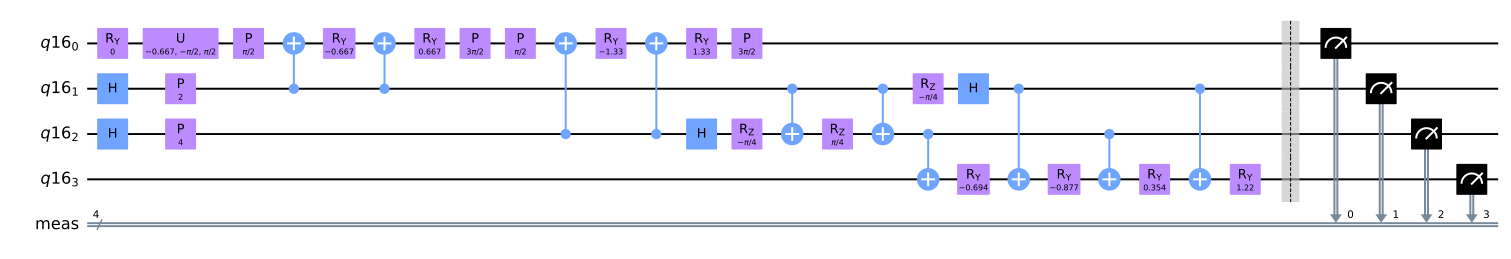

In [8]:
from qiskit import QuantumRegister, QuantumCircuit
import numpy as np

t = 2  # This is not optimal; As an exercise, set this to the
       # value that will get the best results. See section 8 for solution.

nqubits = 4  # Total number of qubits
nb = 1  # Number of qubits representing the solution
nl = 2  # Number of qubits representing the eigenvalues

theta = 0  # Angle defining |b>

a = 1  # Matrix diagonal
b = -1/3  # Matrix off-diagonal

# Initialise the quantum and classical registers
qr = QuantumRegister(nqubits)

# Create a Quantum Circuit
qc = QuantumCircuit(qr)

qrb = qr[0:nb]
qrl = qr[nb:nb+nl]
qra = qr[nb+nl:nb+nl+1]

# State preparation. 
qc.ry(2*theta, qrb[0])
    
# QPE with e^{iAt}
for qu in qrl:
    qc.h(qu)

qc.p(a*t, qrl[0])
qc.p(a*t*2, qrl[1])

qc.u(b*t, -np.pi/2, np.pi/2, qrb[0])


# Controlled e^{iAt} on \lambda_{1}:
params=b*t

qc.p(np.pi/2,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(-params,qrb[0])
qc.p(3*np.pi/2,qrb[0])

# Controlled e^{2iAt} on \lambda_{2}:
params = b*t*2

qc.p(np.pi/2,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(-params,qrb[0])
qc.p(3*np.pi/2,qrb[0])

# Inverse QFT
qc.h(qrl[1])
qc.rz(-np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(-np.pi/4,qrl[0])
qc.h(qrl[0])

# Eigenvalue rotation
t1=(-np.pi +np.pi/3 - 2*np.arcsin(1/3))/4
t2=(-np.pi -np.pi/3 + 2*np.arcsin(1/3))/4
t3=(np.pi -np.pi/3 - 2*np.arcsin(1/3))/4
t4=(np.pi +np.pi/3 + 2*np.arcsin(1/3))/4

qc.cx(qrl[1],qra[0])
qc.ry(t1,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t2,qra[0])
qc.cx(qrl[1],qra[0])
qc.ry(t3,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t4,qra[0])
qc.measure_all()

print("Depth: %i" % qc.depth())
print("CNOTS: %i" % qc.count_ops()['cx'])
qc.draw(fold=-1)

Приведенный ниже код принимает в качестве входных данных нашу схему, реальное аппаратное обеспечение и набор кубитов, которые мы хотим использовать, а также возвращает и экземпляр, который можно запустить на указанном устройстве. Создание цепей с $3$ и $5$ CNOT аналогично вызову метода переноса с правильной квантовой схемой.

Реальные аппаратные устройства нуждаются в регулярной повторной калибровке, и точность конкретного кубита или вентиля может меняться со временем. Кроме того, разные чипы имеют разные возможности подключения. Если мы попытаемся запустить схему, которая выполняет двухкубитный вентиль между двумя кубитами, которые не подключены к указанному устройству, транспилятор добавит вентили SWAP. Поэтому перед запуском следующего кода рекомендуется свериться с веб-страницей IBM Quantum Experience <sup><a href="#qexperience">[7]</a></sup> и выбрать набор кубитов с правильным подключением и наименьшим количеством ошибок в данный момент времени.

In [9]:
from qiskit import execute, BasicAer, ClassicalRegister, IBMQ
from qiskit.compiler import transpile
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, # Measurement error mitigation functions
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)

provider = IBMQ.load_account()

backend = provider.get_backend('ibmqx2') # calibrate using real hardware
layout = [2,3,0,4]
chip_qubits = 5

# Transpiled circuit for the real hardware
qc_qa_cx = transpile(qc, backend=backend, initial_layout=layout)

Следующим шагом является создание дополнительных схем, используемых для уменьшения ошибок считывания <sup><a href="#readouterr">[3]</a></sup> .

In [ ]:
meas_cals, state_labels = complete_meas_cal(qubit_list=layout, qr=QuantumRegister(chip_qubits))
qcs = meas_cals + [qc_qa_cx]

qobj = assemble(qcs, shots=10)
job = backend.run(qobj)

На следующем графике <sup><a href="#tridi">[5]</a></sup> показаны результаты запуска вышеприведенной схемы на реальном оборудовании для $10$ различных начальных состояний. Ось $x$ представляет собой угол $\theta$, определяющий начальное состояние в каждом случае. Результаты были получены после уменьшения ошибки считывания, а затем экстраполяции ошибок, возникающих во время работы схемы, из результатов для схем с CNOT $1$, $3$ и $5$.


<img src="images/norm_public.png">

Сравните с результатами CNOT без устранения ошибок и без экстраполяции <sup><a href="#tridi">5</a></sup> .


<img src="images/noerrmit_public.png"> 

## 8. Проблемы<a id="problems"></a>

1. Запустите алгоритм evo_time: $2\pi(3/8)$. Верность теперь должна быть $ 1 $.

##### Реальное оборудование:

1. Установите параметр времени для оптимизированного примера.

<details><summary>Решение (Нажмите, чтобы развернуть)</summary> т = 2,344915690192344</details>

Наилучший результат - установить его так, чтобы наименьшее собственное значение могло быть представлено точно, поскольку его обратное значение будет иметь наибольший вклад в решение.




1. Создайте транспилированные схемы для $3$ и $5$ CNOT из заданной схемы 'qc'. При создании цепей вам нужно будет добавить барьеры, чтобы эти последовательные вентили CNOT не отменялись при использовании метода transpile().
2. Запустите свои схемы на реальном оборудовании и примените к результатам квадратичную подгонку, чтобы получить экстраполированное значение.

## 9. Ссылки<a id="references"></a>

1. Дж. Р. Шевчук. Введение в метод сопряженных градиентов без мучительной боли. Технический отчет CMU-CS-94-125, Школа компьютерных наук, Университет Карнеги-Меллона, Питтсбург, Пенсильвания, март 1994 г.<a id="conjgrad"></a>
2. А. В. Харроу, А. Хассидим и С. Ллойд, "Квантовый алгоритм для линейных систем уравнений", Phys. Преподобный Летт. 103.15 (2009), с. 150502.<a id="hhl"></a>
3. А. Дьюис, Ф. Р. Онг, В. Шмитт, Р. Лауро, Н. Булант, П. Бертет, Д. Вион и Д. Эстев, «Характеристика процессора с двумя трансмонами с индивидуальным однократным считыванием кубита», Phys. . Преподобный Летт. 108, 057002 (2012).<a id="readouterr"></a>
4. Н. Стаматопулос, Д.Дж. Эггер, Ю. Сун, К. Зуфал, Р. Итен, Н. Шен и С. Вернер, «Оценка опционов с использованием квантовых компьютеров», arXiv:1905.02666.<a id="richardson"></a>
5. А. Каррера Васкес, А. Фриш, Д. Стенкен, Х.С. Баровски, Р. Хиптмайр и С. Вернер, «Улучшение алгоритма квантовой линейной системы с помощью экстраполяции Ричардсона» (будет включено).<a id="tridi"></a>
6. Р. Итен, О. Рирдон-Смит, Л. Мондада, Э. Редмонд, Р. Сингх Коли, Р. Колбек, «Введение в UniversalQCompiler», arXiv:1904.01072 .<a id="qcompiler"></a>
7. https://квантовые вычисления.ibm.com/.<a id="qexperience"></a>
8. Д. Бухер, Дж. Мюггенбург, Г. Кус, И. Хайде, С. Дойчле, Х. Баровски, Д. Стенкен, А. Фриш, «Qiskit Aqua: решение линейных систем уравнений с помощью алгоритма HHL» https:// github.com/Qiskit/qiskit-tutorials/blob/master/legacy_tutorials/aqua/linear_systems_of_equations.ipynb